In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import os
import shutil
import subprocess
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import h2o

In [6]:
project_refactoring_data_agg = pd.read_csv('test_effort_model.csv')

In [7]:
project_refactoring_data_agg.head()

,sha,name,email,date,login,message,parent_sha,parent_date,time_taken,contains_refactoring,...,num_dependency_std,num_line_affected_mean,num_line_affected_min,num_line_affected_max,num_line_affected_std,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,time_taken_final
0,6ad1e4fe77445e8689f6d3975b26e52165c9c3e6,Bin Fan,fanbin103@gmail.com,2021-08-04 02:49:16,apc999,Fix IndexOutOfBoundsException on async cache\n...,df5dcab8bc308dfd2bf650a895865b13120a9866,2021-08-03 16:07:28,10.0,1,...,0.000000,764.000000,764,764,0.000,9.0,9,9,0.000000,10.0
1,8647c6162423b851dda8d10edf4686473d2e95cc,Zac Blanco,zac@alluxio.com,2021-07-15 21:54:27,ZacBlanco,Update and improve conformance of S3 API\n\n##...,79a5e5c78b7dfcdbf8edbd928a2ff59c904d08f8,2021-07-15 18:38:50,3.0,1,...,0.000000,275.000000,275,275,0.000,6.0,6,6,0.000000,3.0
2,3ce52983e6f50bfb7880b5a2cb13a18e4272170b,Zhan Yuan,yuanzhanhku@gmail.com,2021-07-12 06:39:42,yuanzhanhku,Add CacheContext to URIStatus to enable per-re...,cf79c7837c57c83c1b99a1dab53fec25deb2069d,2021-07-10 20:58:13,33.0,1,...,0.000000,115.000000,115,115,0.000,4.5,3,6,2.121320,33.0
3,a4dc54f7dc0333da096aa779dbaa79060c90d1ad,kqhzz,kuangqinghuazz@163.com,2021-06-09 18:09:26,kuszz,Deprecate leader command\n\nFix #13512\n\npr-l...,1356c0b35fd753d1081665b2c8f6b25da62bf2e8,2021-06-09 02:31:45,15.0,1,...,0.000000,61.000000,61,61,0.000,2.0,2,2,0.000000,15.0
4,7fb84094a6075bcef5a103b40adcac4b26b724ca,Jiacheng Liu,jiacheliu3@gmail.com,2021-05-29 00:37:05,jiacheliu3,Refactor MasterWorkerInfo\n\nCurrently all the...,220237085593d731756e24249bcf88a4d6ea5710,2021-05-28 23:28:46,1.0,1,...,93.543216,458.666667,24,1245,682.248,35.0,1,54,29.512709,1.0


In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 mins 11 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,3 months and 2 days
H2O_cluster_name:,H2O_from_python_tanji_k06gu1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.984 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [5]:
model_path = "models/EffortEstimationModelv2/GBM_grid__1_AutoML_20211125_154317_model_2"
saved_model = h2o.load_model(model_path)

In [8]:
prediction_df = h2o.H2OFrame(project_refactoring_data_agg)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [9]:
preds = saved_model.predict(prediction_df)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [13]:
preds = preds.as_data_frame()
preds

,predict
0,7.919424
1,6.570847
2,18.004282
3,32.488578
4,5.651252
...,...
361,9.956820
362,4.604260
363,9.324087
364,1.708048


In [18]:
preds['actual_time_taken'] = project_refactoring_data_agg['time_taken']

In [20]:
preds

,predict,actual_time_taken
0,7.919424,10.0
1,6.570847,3.0
2,18.004282,33.0
3,32.488578,15.0
4,5.651252,1.0
...,...,...
361,9.956820,146.0
362,4.604260,1.0
363,9.324087,1.0
364,1.708048,1.0


In [21]:
def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.title(regressorName)
    plt.show()
    return

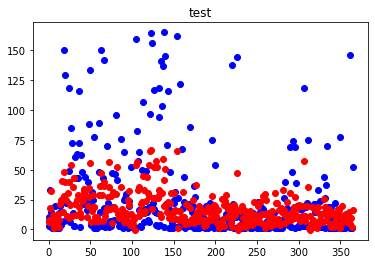

In [25]:
plotGraph(preds['actual_time_taken'],preds['predict'],'test')

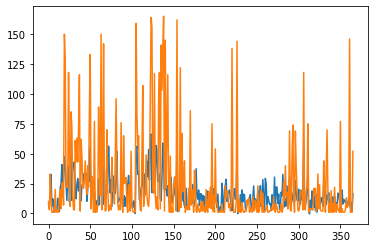

In [19]:
plt.plot(preds)

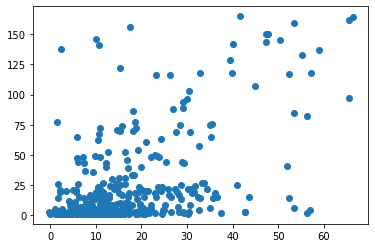

In [15]:
plt.scatter(preds,project_refactoring_data_agg['time_taken'])

In [16]:
preds.shape

(366, 1)

In [17]:
len(project_refactoring_data_agg)

366